# Measurement - Diff-In-Diff method



In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
import pandas as pd
import warnings
import statsmodels.formula.api as smf

warnings.simplefilter("ignore")

pd.set_option("display.max_columns", 8)

# style plots
plt.style.use("data/style/mystyle.mplstyle")

<IPython.core.display.Javascript object>

## California proposition 99

To see it in action, let's consider the problem of estimating the effect of cigarette taxation on its consumption.

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as Proposition 99.
“Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements.”

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the years 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

In [28]:
df = pd.read_csv("data/california_prop99.csv")

<IPython.core.display.Javascript object>

In [6]:
# Pivot data for downstream work, and seperate sales of California and other states. 

inverted = (
    df.assign(
        california=np.where(
            df["State"] == "California", "California", "National average"
        )
    )
    .groupby(["Year", "california"])["PacksPerCapita"]
    .mean()
    .reset_index()
)

inverted = inverted.assign(treated=np.where(inverted["Year"] >= 1989, 1, 0))

inverted.head()

,Year,california,PacksPerCapita,treated
0,1970,California,123.000000,0
1,1970,National average,120.084212,0
2,1971,California,121.000000,0
3,1971,National average,123.863158,0
4,1972,California,123.500000,0


<IPython.core.display.Javascript object>

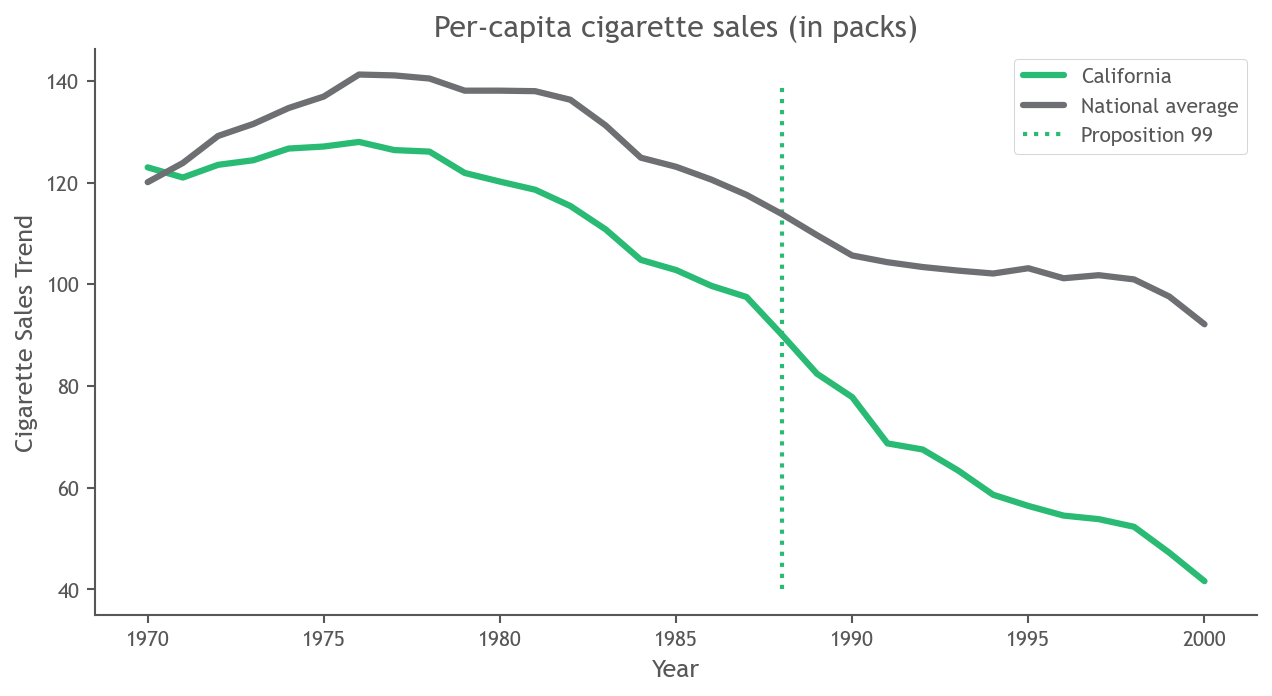

<IPython.core.display.Javascript object>

In [7]:
ax = plt.subplot(1, 1, 1)

inverted.pivot("Year", "california", "PacksPerCapita").plot(
    ax=ax, figsize=(10, 5), lw=3
)

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Per-capita cigarette sales (in packs)")
plt.legend()
plt.show()

In [9]:
inverted.groupby(["treated", "california"])["PacksPerCapita"].mean()

treated  california      
0        California          116.210526
         National average    130.569529
1        California           60.350000
         National average    102.058114
Name: PacksPerCapita, dtype: float64

<IPython.core.display.Javascript object>

Here, you can see the National average pre intervention is 130 packs, while California's sales is slightly lower at 116 packs. 
After intervention, California siginificant decresed the sales to 60 packs per capita, and national average also dropped to 102 packs. 

Below we compare the pre and post sales for California:

In [26]:
cal_pre_intervention = inverted[
    (inverted["treated"] == 0) & (inverted["california"] == "California")
]["PacksPerCapita"].mean()
cal_post_intervention = inverted[
    (inverted["treated"] == 1) & (inverted["california"] == "California")
]["PacksPerCapita"].mean()


print(
    f"The difference of California pre and post intervention is {cal_post_intervention - cal_pre_intervention}"
)

The difference of California pre and post intervention is -55.86052625267542


<IPython.core.display.Javascript object>

In [25]:
national_post_intervention = inverted[
    (inverted["treated"] == 1) & (inverted["california"] == "National average")
]["PacksPerCapita"].mean()

print(
    f"And the difference of California and national average post intervention is {cal_post_intervention - national_post_intervention}"
)

And the difference of California and national average post intervention is -41.70811388026315


<IPython.core.display.Javascript object>

In [27]:
national_pre_intervention = inverted[
    (inverted["treated"] == 0) & (inverted["california"] == "National average")
]["PacksPerCapita"].mean()

diff_in_diff = (cal_post_intervention - cal_pre_intervention) - (
    national_post_intervention - national_pre_intervention
)
diff_in_diff

print(f"Finally the difference in difference is {diff_in_diff}")

Finally the difference in difference is -27.34911108361495


<IPython.core.display.Javascript object>

To visualize what diff-in-diff is doing, we can project the growth trend from the untreated into the treated to see the counterfactual, that is, the sales we should expect if there were no intervention.

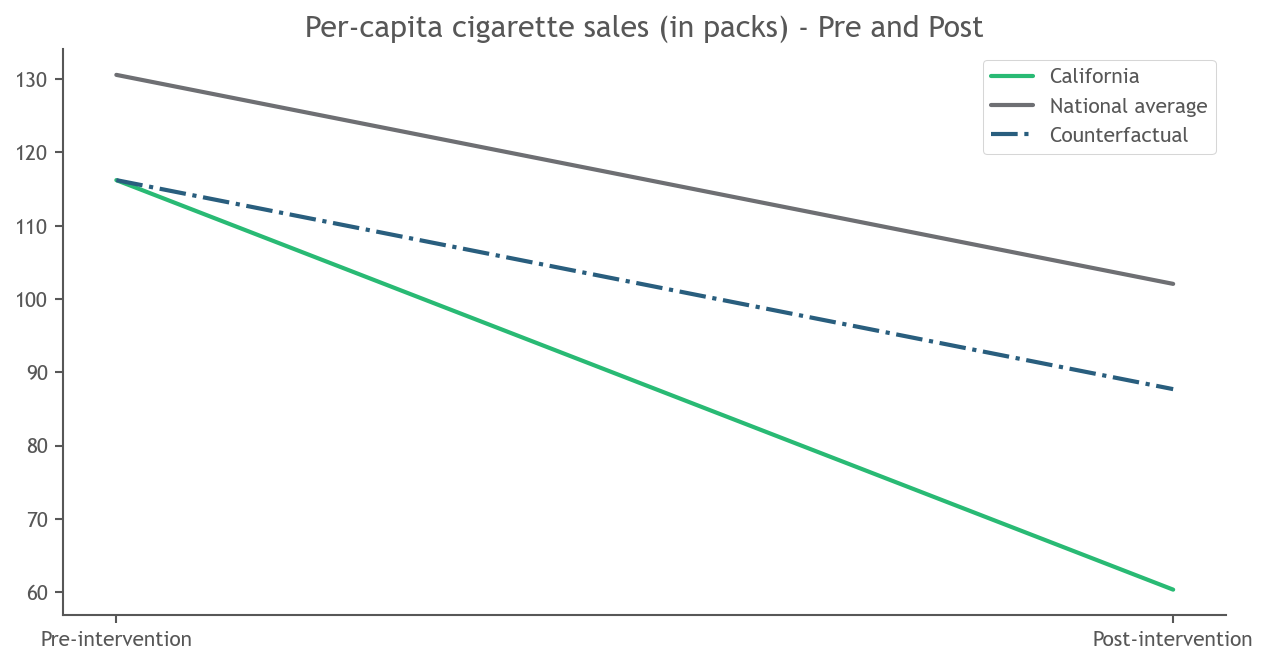

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(
    ["Pre-intervention", "Post-intervention"],
    [cal_pre_intervention, cal_post_intervention],
    label="California",
    lw=2,
)
plt.plot(
    ["Pre-intervention", "Post-intervention"],
    [national_pre_intervention, national_post_intervention],
    label="National average",
    lw=2,
)

plt.plot(
    ["Pre-intervention", "Post-intervention"],
    [
        cal_pre_intervention,
        cal_pre_intervention + (national_post_intervention - national_pre_intervention),
    ],
    label="Counterfactual",
    lw=2,
    color="C2",
    ls="-.",
)
plt.title("Per-capita cigarette sales (in packs) - Pre and Post")
plt.legend()
plt.show()

We can use a linear estimator to do the same trick, more specifically:

$
Y_i = \beta_0 + \beta_1 * treated + \beta_2 * cal + \beta_3 * treated * cal + \epsilon
$

The \\(\beta_0\\) is the baseline of the control, which is the intercept of the regression. 
In our case, it is the packs of cigarette sold National average before 1989. 

The \\(\beta_1\\) is the impact of being in the time period after intervention. Combined with \\(\beta_0\\), we can see the sales of control after intervention. 

We can get sales of California pre intervention from combination of \\(\beta_0\\) and \\(\beta_2\\). 

And finally, if we turn all the dummy variables on, we get the sales of California after intervention. So \\(\beta_3\\) is the incremental impact when you go from pre intervention to post, and switch from national average to California. In other words, it is the difference in difference estimator.

In [18]:
mapping = {"California": 1, "National average": 0}
inverted["cal"] = inverted["california"].replace(mapping)
inverted.head()

,Year,california,PacksPerCapita,treated,cal
0,1970,California,123.000000,0,1
1,1970,National average,120.084212,0,0
2,1971,California,121.000000,0,1
3,1971,National average,123.863158,0,0
4,1972,California,123.500000,0,1


<IPython.core.display.Javascript object>

In [15]:
smf.ols("PacksPerCapita ~ treated*cal", data=inverted).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,130.5695,2.262,57.724,0.000,126.042,135.097
treated,-28.5114,3.636,-7.842,0.000,-35.789,-21.234
cal,-14.3590,3.199,-4.489,0.000,-20.762,-7.956
treated:cal,-27.3491,5.141,-5.319,0.000,-37.641,-17.057


<IPython.core.display.Javascript object>

Here, the model shows that before 1989, national average sales of cigarettes is 130 packs, which matches our previous data. 

The sales post 1989 is 28 packs less than pre 1989 for national average. 
The pre 1989 sales of California is about 130 - 14 = 116 packs. 

Diff in diff is the `treated:cal`, which is -27, same as the diff-in-diff calculation we did previously. The confidence interval is between [-17, 37]. 
